 <center>Assignment 3</center> 


## Question 1 ##

### Read data

In [34]:
import pandas as pd
import numpy as np

# read data
data = pd.read_csv('Mamani09_Table_DR2.csv', encoding='cp1252')
# data.info(verbose=True, null_counts=True)
print('data length:',len(data))
print('numbers of column \'sample\' unique value', len(data['Sample'].unique()))

data length: 1788
numbers of column 'sample' unique value 1779


### Data clearning


#### Drop some columns and change null value of Rock_type
From the information and analysing, some columns is less data or irrelvant to sample feature, it can take action by following steps: 
1. There are many columns that have a lot of null values. It should be deleted if the null value is more than ***70%***. 

2. Our goal is to predict `Sample_type` column, if the sample type value is null, it can be assumed that the data is missing and that row should be deleted 

3. Some columns also need to be deleted:
  1. Column *'Sample'* have 1779 unique value, It almost has the number of data length, so it is too identical to find extra common information
  2. columns *'Location'*, *'Geochemistry Reference'*, *'Country'*, *'Longitude (X)'*, *'Latitude (Y)'* is not the characteristics of the sample itself, can be deleted
4. Column *'Rock_type'* have three value is null, it can be named as 'unknown'

In [35]:
# get each colum null numbers
data_isnull_nums = data.isnull().sum().sort_values()
# drop columns that contain more than 70% null value
drop_cols = data_isnull_nums[data_isnull_nums>len(data)*.7].index 

# drop row item if target value (Sample type value) is null
data_cleaning = data.drop(drop_cols, axis=1)
data_cleaning = data_cleaning[~data_cleaning['Sample_type'].isnull()]

# drop the columns which is not related to the characteristics of the sample itself
data_cleaning.drop(['Sample', 'Location', 'Geochemistry Reference', 'Country', 'Longitude (X)', 'Latitude (Y)'], axis=1, inplace=True)

# rename null value to 'unknown' in the 'Rock_type'
data_cleaning['Rock_type'] = data_cleaning['Rock_type'].apply(lambda x: 'unknown' if str(x) == 'nan' else x)

### Feature transformation

#### Convert **object** columns to **float64** columns
Then, there are some columns that seems is float, but include some extra symbol, like ``<`` or ``-``, we should delete it and change the value to float

In [36]:
data_cleaning2 = data_cleaning\
  .applymap(lambda x: x.strip() if type(x) is str else x)\
  .replace('-','')\
  .replace(r'<|<=|=|>|>=', '', regex=True)\
  .replace('',np.nan)\
  .astype('float', errors='ignore')

# watch the info
# data_cleaning2.info(verbose=True, null_counts=True)

#### Impute value and add xx(feature)_was_missing columns
Using the **median** of each column value to impute the null value by `SimpleImputer`, and **mark the null data** by adding boolean column (``[feature_name]_was_missing``).

In [37]:
import warnings
# Ignore the chain warning and the least populated class number which is smaller than split number
warnings.filterwarnings('ignore') 

data_float64 = data_cleaning2.select_dtypes('float64')

col_with_missing = [col for col in data_cleaning2.columns if data_cleaning2[col].isnull().any()]
for col in col_with_missing:
  data_float64.loc[:, col+'_was_missing'] = data_float64[col].isnull().astype(int) # add column

from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='median')

data_float64_cols = data_float64.columns

data_float64[data_float64_cols] = si.fit_transform(data_float64) # replace null value of column median value

# data_float64.isnull().any().unique(), data_float64.shape



#### Transform all the non-numeric features into numbers.
Using **One Hot Encoder** to change input features to numeric columns and using **Label Encoder** to change output(Sample_type) column to number.

Besides, fix the **multicollinearity** by dropping each one of the input subcolumns.

In [38]:
from sklearn.preprocessing import OneHotEncoder

data_nonnum = data_cleaning2.select_dtypes('object') # select the object cols
data_nonnum.drop('Sample_type', inplace=True, axis=1)# drop target value column

ohe = OneHotEncoder(sparse=True)# using one hot encoder
ohe.fit(data_nonnum)

# get the transform data 
data_nonnum2_columns = ohe.get_feature_names_out(data_nonnum.columns).tolist()
data_nonnum2 = pd.DataFrame(ohe.fit_transform(data_nonnum).toarray(), columns=data_nonnum2_columns)

# drop one subcolumn to avoid multicollinearity
for col in data_nonnum.columns:
  sub_col1 = [col2 for i, col2 in enumerate(data_nonnum2_columns) if col in col2][0]
  data_nonnum2.drop(sub_col1, axis=1, inplace=True)
data_trans = data_nonnum2.join(data_float64)

# convert dependent column (Sample_type)'s type from object to float64
from sklearn.preprocessing import LabelEncoder # using label encoder
le = LabelEncoder()
y = le.fit_transform(data_cleaning2['Sample_type'])
y_classes = le.classes_

# print the result
data_trans.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786 entries, 0 to 1785
Data columns (total 241 columns):
 #    Column                                  Non-Null Count  Dtype  
---   ------                                  --------------  -----  
 0    Arc_Chocolate                           1786 non-null   float64
 1    Arc_Frontal arc                         1786 non-null   float64
 2    Arc_Huaylillas                          1786 non-null   float64
 3    Arc_Huaylillas backarc                  1786 non-null   float64
 4    Arc_Huaylillas backarc-Ignimbrite       1786 non-null   float64
 5    Arc_Huaylillas-Alpabamba-Ignimbrite     1786 non-null   float64
 6    Arc_Huaylillas-Azapa                    1786 non-null   float64
 7    Arc_Huaylillas-Chucal-Ignimbrite        1786 non-null   float64
 8    Arc_Huaylillas-Ignimbrite               1786 non-null   float64
 9    Arc_Huaylillas-Mauri-Ignimbrite         1786 non-null   float64
 10   Arc_Huaylillas-Oxaya                    1786 n

#### Feature scalling

Using Standardization to scale features

In [39]:
from sklearn.preprocessing import StandardScaler
stds = StandardScaler() # scalling

features = data_trans.columns
X = stds.fit_transform(data_trans) 

## Question 2
Using algorihms **Naive Bayes** and **Decision Tree**

### Build model with default hyperparameter and train it

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

clf = DecisionTreeClassifier()
nb = GaussianNB()
clf_predict_val = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
nb_predict_val = cross_val_score(nb, X, y, cv=10, scoring='accuracy')

print('Navie Bayes', nb_predict_val)
print('Decision Tree', clf_predict_val)
print('Navie Bayes average accuracy: {}/n Decision Tree average accuracy: {}'.format(nb_predict_val.mean(), clf_predict_val.mean()))

Navie Bayes [0.75977654 0.51396648 0.48044693 0.58659218 0.59776536 0.70391061
 0.75280899 0.96067416 0.70224719 0.19662921]
Decision Tree [0.74301676 0.73743017 0.93854749 0.93854749 0.91061453 0.95530726
 0.88202247 0.85393258 0.91011236 0.40449438]
Navie Bayes average accuracy: 0.6254817651120457/n Decision Tree average accuracy: 0.8274025484903647


### Analysis models

#### Metric **Accruracy**, its distribution (boxplot) and Mann-Whitney U Test

##### **Boxplot**

The boxplot shows the distribution of outliers, maximum, 3rd quartile, median, 1st quartile, minimum, and more intuitive data distribution. To facilitate our general analysis.

This plot, it shows how the accuracy is distributed. The result is that the Decision Tree model has a better distribution of accuracy, which has a higher median value and higher narrow range of value distribution.


##### **Mann-Whitney U Test**:

In this case, each of the two models is testing different part of data 10 times, so it is **unpair** and independent and identically distributed (**iid**). Besides, each model **only has 10 accuracy results**, the sample size is too small. Thus it can use Mann-Whitney U Test to do it.

Mann-Whitney U Test shows the p-value of these two data is about ***0.01***, smaller than 0.05. It means their performance is **significantly different**, and the Decision tree is way better than Naive Bayes in the metric of accuracy.





MannwhitneyuResult(statistic=22.0, pvalue=0.03756347188589839)


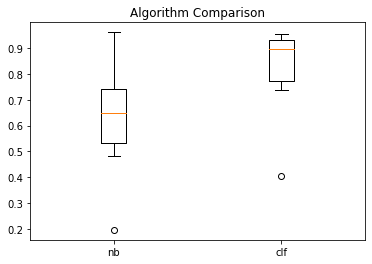

In [41]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# draw boxplot
plt.title('Algorithm Comparison')
plt.boxplot([nb_predict_val, clf_predict_val])
plt.xticks(np.arange(1,3), ['nb', 'clf'])


# test
print(mannwhitneyu(nb_predict_val, clf_predict_val))

#### using **confusion matrix** and **F-measure**

##### **Confusion Matrix**
The matrix can show more details about how predicted classes match the right classes.

Comparing the Decision Tree model, The predicted value of the Naive Bayes model is not more focused on the diagonal. Such as the prediction of *lava* class, has many misjudgments as *ignimbrite* and *intrusion*.

##### **F-measure**
Then after 10 folder cross-validation, using **macro f-measure values** to judge two models. Using **Mann-Whitney U Test** to know if the results of the two models are significantly different. And the reason why using this test method is similar to the above. The statistic results show that:
1. The average macro f-score in the Decision tree is slightly better than Naive Bayes.
2. Besides, the p-value of these two methods is larger than 0.05. It means their performance is probably 95% same 

Naive Bayes: f-measureaverage score:0.6701086525906537
Decision Tree: f-measure average score:0.7457944763545181
MannwhitneyuResult(statistic=43.0, pvalue=0.6231762238821174)


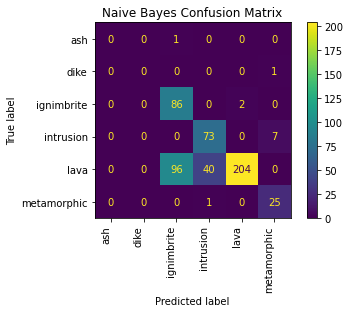

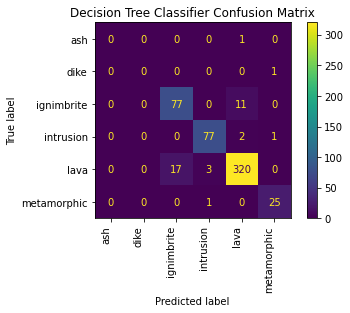

In [42]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

# get train and test subsets and fit two models 
nb = GaussianNB()
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)
nb.fit(X_train, y_train)
clf.fit(X_train, y_train)

# Naive Bayes Confusion Matrix
predict_val1 = nb.predict(X_test)
cm1 = confusion_matrix(y_test, predict_val1)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=y_classes)
disp1.plot()
disp1.ax_.set_title('Naive Bayes Confusion Matrix')
disp1.figure_.autofmt_xdate(rotation=90)

# Decision Tree Classifier Confusion Matrix
predict_val2 = clf.predict(X_test)
cm2 = confusion_matrix(y_test, predict_val2)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=y_classes)
disp2.plot()
disp2.ax_.set_title('Decision Tree Classifier Confusion Matrix')
disp2.figure_.autofmt_xdate(rotation=90)


# using macro average f-measure to judge two models, 
nb_f1 = cross_val_score(GaussianNB(), X, y, cv=10, scoring='f1_macro')
clf_f1 = cross_val_score(DecisionTreeClassifier(), X, y, cv=10, scoring='f1_macro')
print('Naive Bayes: f-measureaverage score:{}\nDecision Tree: f-measure average score:{}'.format(nb_f1.mean(), clf_f1.mean()))

# using mannwhitneyu to test if two models result is significantly different.
print(mannwhitneyu(nb_f1, clf_f1))

## Question 3



### Tuning the hyperparameter to imporve Decision Tree Model

After selecting the decision tree model, we can tune the hyperparameter by `GridSearchCV` to get the best model and judge it through accuracy.

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# set the range of hyperparameter
clf_hyperparams = dict(
    criterion=['gini', 'entropy'],
    max_depth=np.arange(10,40),
    min_samples_split=np.arange(3, 6),
)

# get the best hyperparameter
gridSearch = GridSearchCV(DecisionTreeClassifier(), clf_hyperparams, scoring='accuracy')
clf_params_results = gridSearch.fit(X, y)

### Compare two decision tree models (default hyperparameter and tuned hyperparameter)

After tuning the hyperparamers and applying them to the model, the average accuracy is slightly arisen and is better than before. However, from the statistic point, after using Mann-Whitney U Test, it shows that the performances of these two models are 95% probably same. Although the accuracy has been improved, it still has 95% is a similar accuracy distribution with the untuned model.

In [44]:
# print(clf_params_results.best_params_, clf_params_results.best_score_)
clf_tuned_params = clf_params_results.best_params_
clf_tuned_val = cross_val_score(
    DecisionTreeClassifier(
      criterion=clf_tuned_params['criterion'], 
      max_depth=clf_tuned_params['max_depth'], 
      min_samples_split=clf_tuned_params['min_samples_split']
    ),
    X, y, scoring='accuracy', cv=10
)

print('origin mean accuracy: {}'.format(clf_predict_val.mean()))
print('after tuning mean accuracy: {}'.format(clf_tuned_val.mean()))
mannwhitneyu(clf_predict_val, clf_tuned_val)

origin mean accuracy: 0.8274025484903647
after tuning mean accuracy: 0.8678425710878163


MannwhitneyuResult(statistic=46.5, pvalue=0.8204630988382954)